# Age, Cholesterol, Blood Pressure, and Chest Pain in Determining Heart Disease

Andy Hong, Celine Li, Jason Shi, Ibrahim Saeed

For our data analysis, we will only analyze the predictor variables age, chestpain, resting blood pressure and cholestrol level. This is because based on our background knowledge around heart disease, (and for the sake of time and computational power when we use forward selection to determine the best predictors) we believe these variables are most relevant compared to the other variables when it comes to determining whether a patient has heart diesease.

# Preliminary Data Analysis

In [1]:
# Here we load the packages necessary to run our functions
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

Preliminary Exploratory Data Analysis

In the code below, we can prove that the dataset can be read from the web. We will be naming the dataset "heart_data".  


In [2]:
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
                       col_names = FALSE)
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


We notice that there are no column names for the data set thus we will need to add column names based on what each column represents.

In [3]:
names <- c("age","sex","cp","trestbps",
           "chol","fbs","restecg","thalach",
           "exang","oldpeak","slope",
           "ca","thal","num")

colnames(heart_data) <- names
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,0


Let's select for the columns we are interested in and tidy it up. Note that the "num" column tells us the prescence of heart disease within a patient, with a value of 0 meaning no heart disease present and a value of 1 meaning heart disease is present with greater values representing how significant the prescence is all the way up to the maximum value of 4. 

In [4]:
heart_data_select <- select(heart_data, age, cp, trestbps, chol, num) 
slice(heart_data_select,1:5)


age,cp,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,145,233,0
67,4,160,286,2
67,4,120,229,1
37,3,130,250,0
41,2,130,204,0


Each row is one unique obsevation and each cell only contains one value. But we are only interested in whether a patient has heart diesease or not. Let's transform the "num" column and make a new column called "diag" of type factor  (abbreviation for diagnosis) so that values equal to 0 translate to "FALSE" which means no heart disease is present whereas any values higher than 0 gets the value "TRUE" which means heart diesease is present. 

In [5]:
heart_clean <- heart_data |>
                       mutate(diag = factor(ifelse(is.na(num), NA,  (num > 0)))) |>
                       select(-num,-sex,-thal,-ca)
heart_clean



age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,1,2,150,0,2.3,3,FALSE
67,4,160,286,0,2,108,1,1.5,2,TRUE
67,4,120,229,0,2,129,1,2.6,2,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,131,0,0,115,1,1.2,2,TRUE
57,2,130,236,0,2,174,0,0.0,2,TRUE
38,3,138,175,0,0,173,0,0.0,1,FALSE


Now let's check to see if any missing values. To do this, we can inbed the is.na() function into the sum() function. 

In [6]:
sum(is.na(heart_data_select))

[1] 0

The value 0 tells us that there are no missing values in our data frame. 

Let's separate our training data from the testing data, set a seed, and summarize the training idea to get a good idea of what we are working with.

In [7]:
#splitting dataframe into training, testing datasets
set.seed(1)

heart_split <- initial_split(heart_clean, prop = 3/4, strata = diag)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_clean

age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,diag
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,145,233,1,2,150,0,2.3,3,FALSE
67,4,160,286,0,2,108,1,1.5,2,TRUE
67,4,120,229,0,2,129,1,2.6,2,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,4,130,131,0,0,115,1,1.2,2,TRUE
57,2,130,236,0,2,174,0,0.0,2,TRUE
38,3,138,175,0,0,173,0,0.0,1,FALSE


We then can summarize our training data into a table below.

In [8]:
#summarizing training data into a table and getting mean, min, max
heart_summarized <- heart_training %>%
group_by(diag) %>%
summarize(min_age = min(age), max_age = max(age), mean_age = mean(age),
          min_cp  = min(cp), max_cp = max(cp), mean_cp = mean(cp),
          min_chol = min(chol), max_chol = max(chol), mean_chol = mean(chol),
          min_trestbps = min(trestbps), max_trestbps = max(trestbps), 
                             mean_trestbps = mean(trestbps), no_patients = n())
heart_summarized
          
          


diag,min_age,max_age,mean_age,min_cp,max_cp,mean_cp,min_chol,max_chol,mean_chol,min_trestbps,max_trestbps,mean_trestbps,no_patients
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,29,76,52.96748,1,4,2.788618,157,417,243.9106,94,180,130.4553,123
TRUE,35,77,57.23077,1,4,3.596154,131,407,250.5673,100,180,135.5096,104


We see that there are no anomalies and the number of observations with respect to the diagnosis value (whether or not the patent has heart diesease) is fair. "no_patients" tells us the number of rows. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



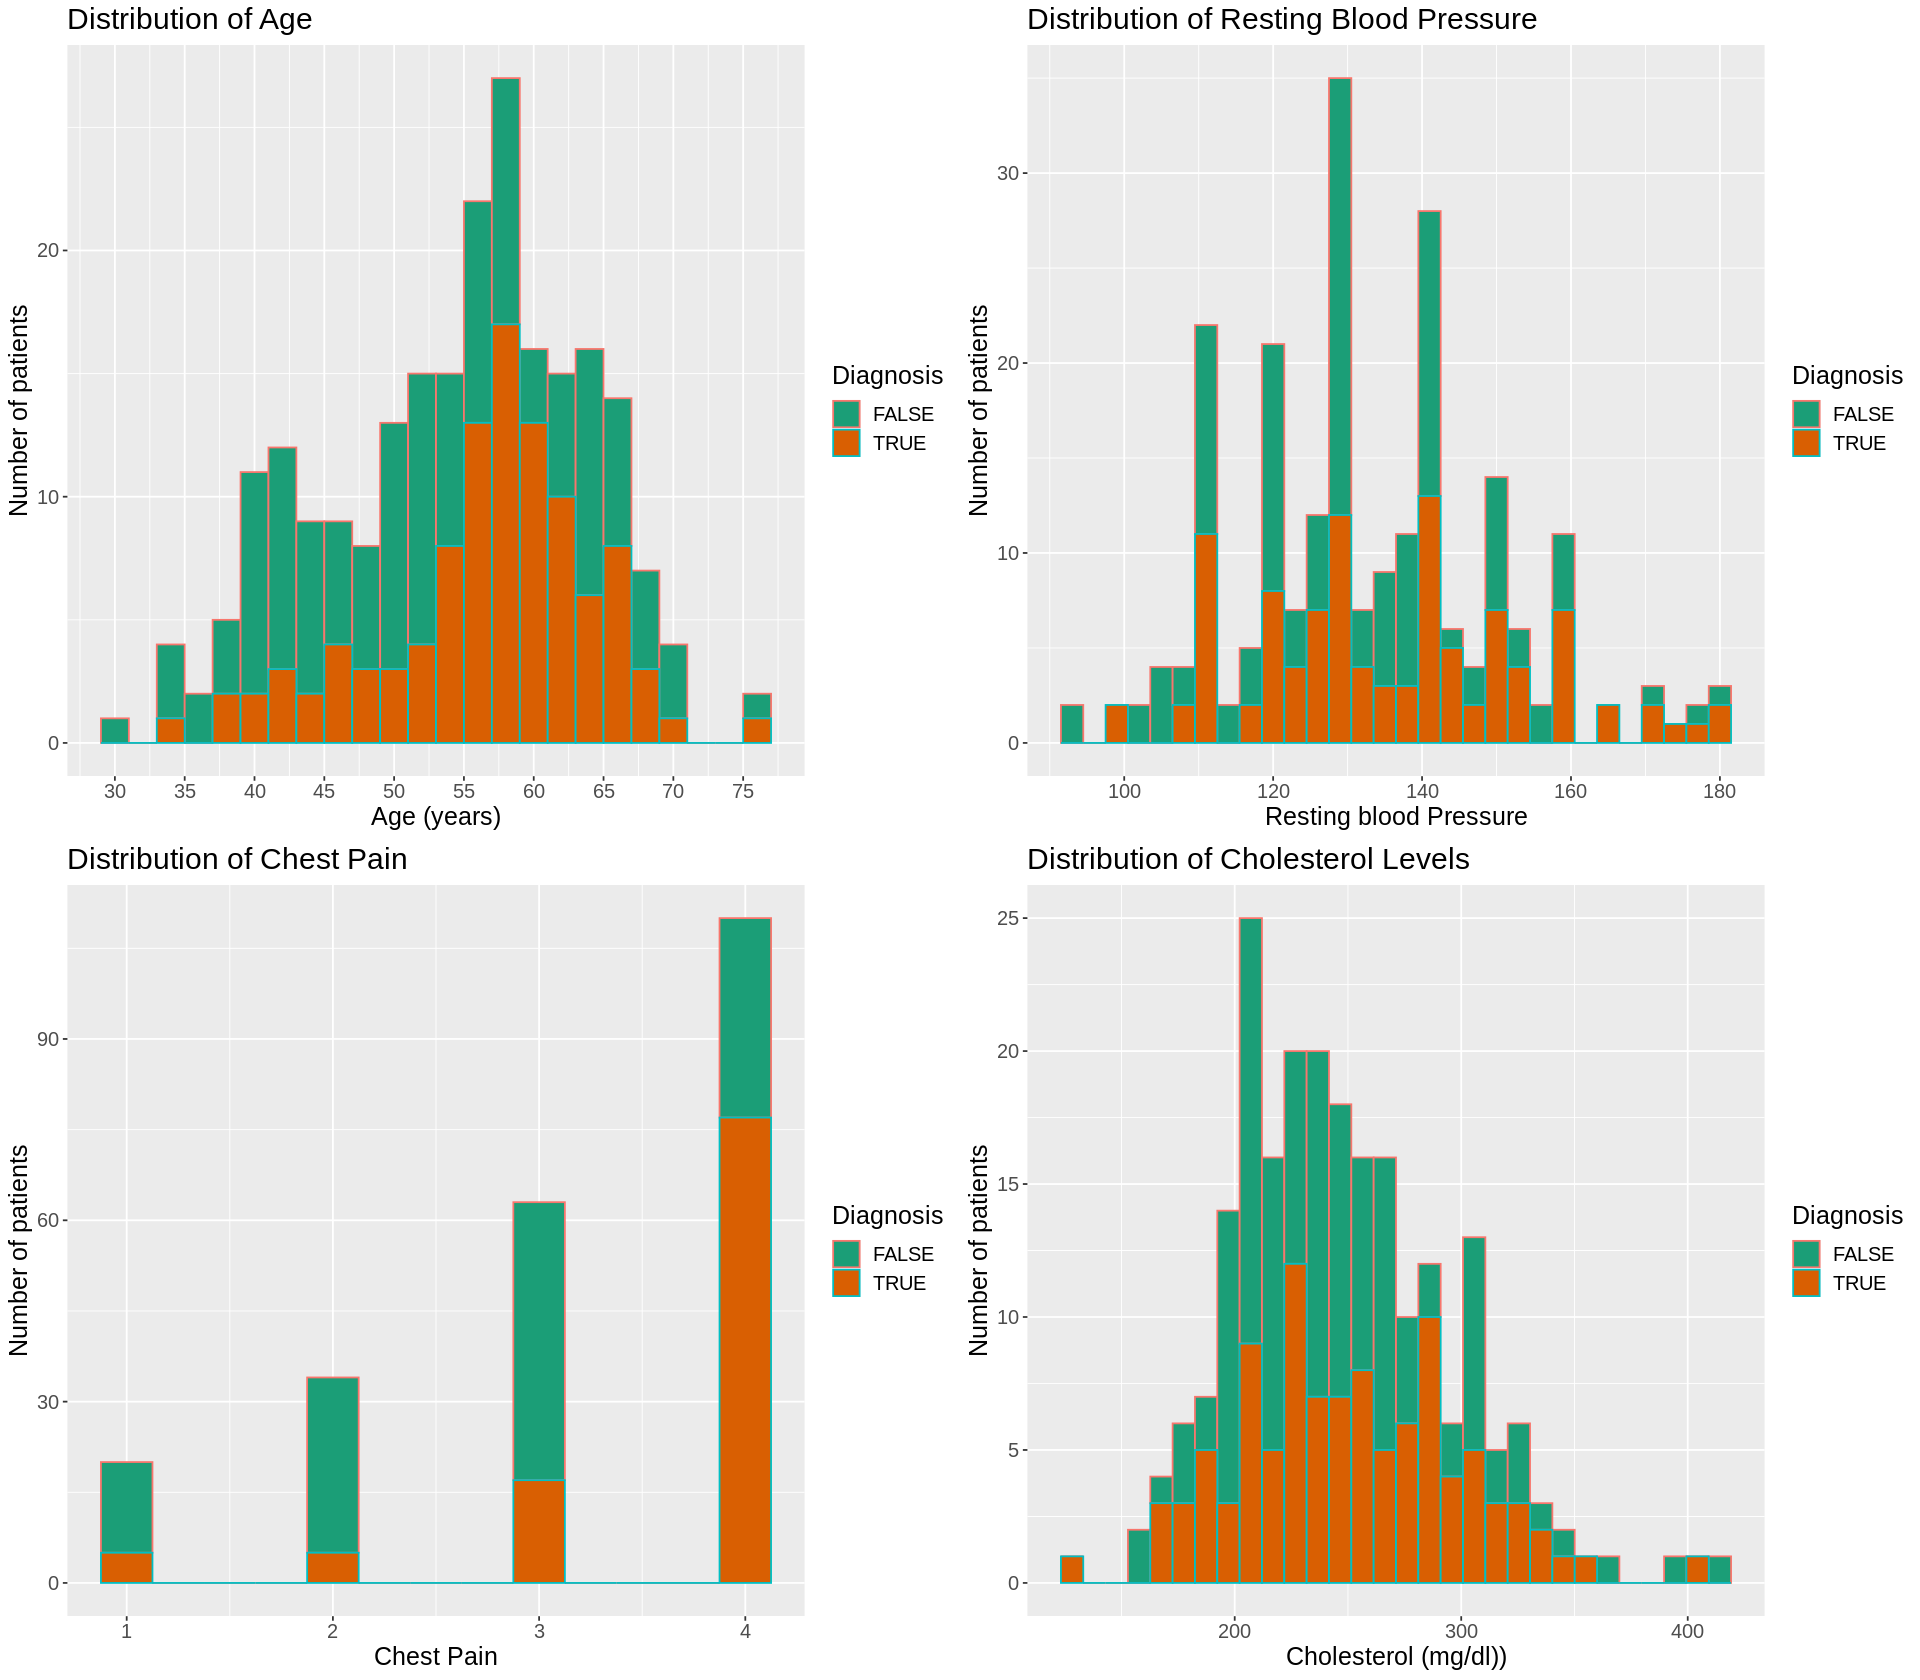

In [9]:
#Plotting this data to find correlation of diagnosis
options(repr.plot.width = 8, repr.plot.height = 7)

# RColorBrewer features for color blindness 
library(RColorBrewer)


graph <- ggplot(heart_training, aes(x = age, fill = diag, color = diag)) +
                 geom_histogram(binwidth=2) +
                 labs(x = "Age (years)", y = "Number of patients", color = "Diagnosis", fill = "Diagnosis", 
                      title = "Distribution of Age") +
                 theme(text = element_text(size = 15)) +
                 scale_x_continuous(breaks = seq(20, 80, by = 5)) +
                 scale_fill_brewer(palette = "Dark2") 

graph2 <- ggplot(heart_training, aes(x = cp, color = diag, fill = diag)) +
                 geom_histogram(bins = 13) +
                 labs(x = "Chest Pain", y = "Number of patients", color = "Diagnosis", fill = "Diagnosis", 
                      title = "Distribution of Chest Pain") +
                 theme(text = element_text(size = 15))+
                 scale_fill_brewer(palette = "Dark2") 

graph3 <- ggplot(heart_training, aes(x = trestbps, color = diag, fill = diag)) +
                 geom_histogram(binwidth=3) +
                 labs(x = "Resting blood Pressure", y = "Number of patients",
                      color = "Diagnosis", fill = "Diagnosis", title = "Distribution of Resting Blood Pressure") +
                 theme(text = element_text(size = 15))+
                 scale_fill_brewer(palette = "Dark2") 

graph4 <- ggplot(heart_training, aes(x = chol,  color = diag, fill = diag)) +
                 geom_histogram() +
                 labs(x = "Cholesterol (mg/dl))", y = "Number of patients", 
                      color = "Diagnosis", fill = "Diagnosis", title = "Distribution of Cholesterol Levels") +
                 theme(text = element_text(size = 15))+
                 scale_fill_brewer(palette = "Dark2") 

#To make visulations bigger 
options(repr.plot.width = 16, repr.plot.height = 14)
plot_grid(graph,graph2,graph3,graph4, byrow = FALSE, 
          ncol = 2, nrow = 2) 



Based on the Distribution of Age graph above, we see that most of the patients in the training set have heart disease present in their late fifties, but also that most of the patients are in their late fifites. Most values are concentrated between the ages of 50 and 65 though there are a few values outside of that range. A very small portion of the patients are beyond the age of 75. 

The Distribution of Resting Blood Pressure graph does not seem to have a center where people with heart disease are concentrated in. We do notice that most of the patients with a resting blood pressure beyond 160 have heart disease, though the total number of patients with a resting blood pressure beyond 160 is small.

The Distribution of Chest Pain graph shows that most patients have a chest pain level of 4 which is severe chest pain. Most patients with a chest pain of value 4 are diagnosed with heart disease. 

The Distribution of Cholestrol Levels graph has most values concentrated between a cholestrol level of 200 to 300. Based on this graph, most of the patients with heart disease seem to have a cholestrol level between 200 to 300 though there is no center as the shape created from values of patients with heart disease forms a rectangular like shape. There are also some anomalies, as there are patients with a cholestrol level around 400 and near 100. 

## Predictor Variable Selection Analysis 

To figure out the best predictor variables to use for our classifier, we will be using the Foward Selection method. 
First, let's select for the predictors we are working with and get the column names of our predictor variables. 

In [10]:
options(repr.plot.width = 8, repr.plot.height = 7)
heart_sub <- heart_clean |>
             select(diag, 
                    c("age","cp","trestbps",
           "chol","fbs","restecg","thalach",
           "exang","oldpeak","slope",
           "diag") )
pred_names <- colnames(heart_sub |> select(-diag))
heart_sub

diag,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FALSE,63,1,145,233,1,2,150,0,2.3,3
TRUE,67,4,160,286,0,2,108,1,1.5,2
TRUE,67,4,120,229,0,2,129,1,2.6,2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,57,4,130,131,0,0,115,1,1.2,2
TRUE,57,2,130,236,0,2,174,0,0.0,2
FALSE,38,3,138,175,0,0,173,0,0.0,1


Now let's create a model formula using the paste function. We will be naming this heart_formula.

In [11]:
heart_formula <- paste("diag", "~", paste(pred_names, collapse = "+"))
heart_formula

[1] "diag ~ age+cp+trestbps+chol+fbs+restecg+thalach+exang+oldpeak+slope"

Lastly, we will create the code to find the best predictors for our purposes. 

(Note: Scaffolding of code below provided from datasciencebook.ca under chapter 6.8. This is cited properly in APA format under references)

In [12]:
set.seed(1) 

# Empty tibble to store our results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Here, we create the model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# Here, we use a 5-fold cross validation for the sake of time and computational power 
heart_vfold <- vfold_cv(heart_sub, v = 5, strata = diag)

# Stores number of total predictors
n_total <- length(pred_names)

# Stores the selected predictors
selected <- c()

# Iterates from 1 to the total number of predictors
# Outside part of nested for loop 
for (i in 1:n_total) {    
    accs <- list()
    models <- list()
    
    # Iterates until every predictor is added 
    #Inside part of nested for loop 
    for (j in 1:length(pred_names)) {
        
        # Model string for this combination of predictors
        preds_new <- c(selected, pred_names[[j]])
        model_string <- paste("diag", "~", paste(preds_new, collapse="+"))

        # Recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_sub) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # Here, we tune the classifier with our chose predictors
        # and collect the estimated accuracy
        
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        
        # Adding the results to the dataframe
        
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, pred_names[[jstar]])
    pred_names <- pred_names[-jstar]
}
accuracies


size,model_string,accuracy
<int>,<chr>,<dbl>
1,diag ~ cp,0.7587663
2,diag ~ cp+oldpeak,0.7819394
3,diag ~ cp+oldpeak+age,0.7857738
⋮,⋮,⋮
8,diag ~ cp+oldpeak+age+restecg+fbs+exang+trestbps+thalach,0.7724368
9,diag ~ cp+oldpeak+age+restecg+fbs+exang+trestbps+thalach+chol,0.7726591
10,diag ~ cp+oldpeak+age+restecg+fbs+exang+trestbps+thalach+chol+slope,0.7692692


Let's plot the number of predictors against the estimated accuracy to see which group of predictors let us obtain the highest accuracy.

size,model_string,accuracy
<int>,<chr>,<dbl>
1,diag ~ cp,0.7587663
2,diag ~ cp+oldpeak,0.7819394
3,diag ~ cp+oldpeak+age,0.7857738
4,diag ~ cp+oldpeak+age+restecg,0.7917755
5,diag ~ cp+oldpeak+age+restecg+fbs,0.7786607
6,diag ~ cp+oldpeak+age+restecg+fbs+exang,0.7526535


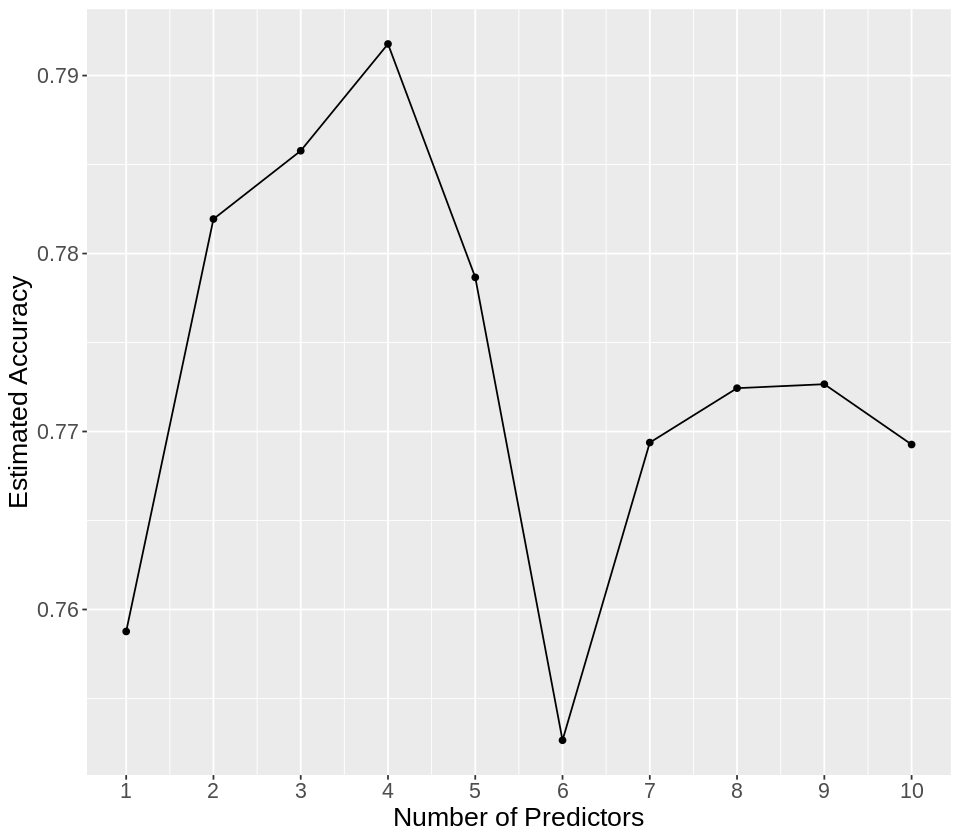

In [13]:
best_pred_plot <- accuracies |>
                  ggplot( aes(x = size, y = accuracy)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Number of Predictors", y = "Estimated Accuracy") +
                  theme(text = element_text(size = 16)) +
                  scale_x_continuous(breaks = seq(0, 10, by = 1))
best_pred_plot
head(accuracies)

From this plot, we see that when we use these *"8"* predictors: (Type all the predicors here), we obtain the highest accuracy and thus for our classification problem these are the predictor variables that we shall use when building our model. 



(Note: Above I used all the variables except sex, ca, and thal; result took incredibly long to compute though; originally I used age,cp,trestbps, and chol and on highest obtained a 76% accuracy; here is a screenshot link to see my results originally: https://prnt.sc/zeWsy5Jv6TaY ; latter result took much shorter to run but still around ~1-2min)



Nothing is running right now because jupyter is dying but here is a screenshot link of my results rightnow using all the variables 
https://prnt.sc/X24aIuVwuBsV


# Classification Code

In [14]:
#Making recipe 
heart_recipe <- recipe(diag ~ age,cp,trestbps,chol , data = heart_training)%>%
    step_center(all_predictors()) %>%
    step_scale(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

Operations:

Centering for all_predictors()
Scaling for all_predictors()

In [25]:
#5vfold here
set.seed(1)
heart_5vfold <- vfold_cv(heart_training, v = 5, strata = diag)
#heart_5vfold

In [26]:
#Tune here for best K 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [27]:
#Get results and collect them 
knn_results <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = heart_5vfold, grid = 20) %>%
    collect_metrics()
knn_results 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5065788,5,0.02464995,Preprocessor1_Model01
1,roc_auc,binary,0.4802381,5,0.02361012,Preprocessor1_Model01
2,accuracy,binary,0.4758454,5,0.02025244,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.6364583,5,0.02563624,Preprocessor1_Model14
15,accuracy,binary,0.5768204,5,0.01988619,Preprocessor1_Model15
15,roc_auc,binary,0.6411250,5,0.02257474,Preprocessor1_Model15


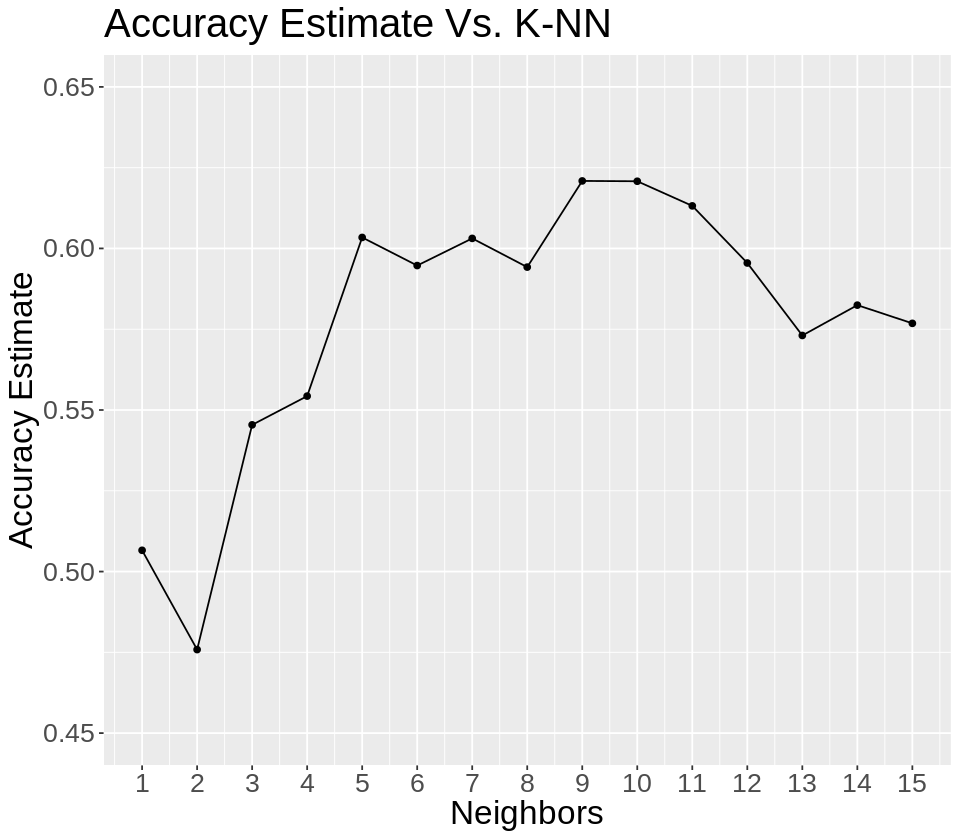

In [28]:
#Graph out relevant columns to see which K-value gives the highest accuracy 
heart_accuracies <- knn_results %>% 
    filter(.metric == "accuracy")
options(repr.plot.width = 8, repr.plot.height = 7)
cross_val_plot <- ggplot(heart_accuracies, aes(x = neighbors, y = mean))+
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy Estimate Vs. K-NN") +
    scale_x_continuous(breaks = seq(0, 15, by = 1)) +  
    scale_y_continuous(limits = c(0.45, 0.65)) +  
    theme(text = element_text(size = 20)) 
cross_val_plot

In [29]:
#Select best K-Value based off highest accuracy
best_k_value <-  heart_accuracies |>
                  filter(mean == max(mean)) |> 
                  slice(1) |>
                  pull(neighbors)
best_k_value

[1] 9

In [30]:
#Creating the classification model with the best K value 
mnist_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) %>%
    set_engine("kknn") %>%
    set_mode("classification")
mnist_spec

mnist_fit <- workflow() %>%
    add_recipe(heart_recipe) %>%
    add_model(mnist_spec) %>%
    fit(data = heart_training)
mnist_fit 

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = best_k_value
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3348018
Best kernel: rectangular
Best k: 9

In [31]:
#Use our model to make predictions on testing data
mnist_predictions <- predict(mnist_fit, heart_testing) %>%
    bind_cols(heart_testing) 
mnist_predictions


# mnist_conf_mat <- mnist_predictions %>%
#     conf_mat(truth = quality, estimate = .pred_class) 
# mnist_conf_mat

.pred_class,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,diag
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
FALSE,56,2,120,236,0,0,178,0,0.8,1,FALSE
TRUE,62,4,140,268,0,2,160,0,3.6,3,TRUE
FALSE,57,4,120,354,0,0,163,1,0.6,1,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
FALSE,45,1,110,264,0,0,132,0,1.2,2,TRUE
FALSE,57,2,130,236,0,2,174,0,0.0,2,TRUE
FALSE,38,3,138,175,0,0,173,0,0.0,1,FALSE


In [32]:
#Results of our predictions 
mnist_metrics <- mnist_predictions %>%
    metrics(truth = diag, estimate = .pred_class) |>
            filter(.metric == "accuracy")
mnist_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5526316


In [24]:
#Results of our prediction based on confusion matrix
mnist_conf_mat <- mnist_predictions %>%
    conf_mat(truth = diag, estimate = .pred_class) 
mnist_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE    35   28
     TRUE      6    7

# References

Janosi, A., Steinbrunn, W., Pfisterer, M., &amp; Detrano , R. (2007). Heart Disease Data Set. Index of/ml/machine-learning-databases/heart-disease. Retrieved December 1, 2022, from https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/ 

Campbell, T., &amp; Timbers, T. (2022, September 24). Data science. Chapter 6 Classification II: evaluation &amp; tuning. 
Retrieved     December 1, 2022, from https://datasciencebook.ca/classification2.html#predictor-variable-selection 